# Incremental Capacity Analysis of Retired Drill Packs

In [1]:
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import math
#import datetime
from datetime import datetime
import csv
import scipy
# from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema


Bad key "text.kerning_factor" on line 4 in
/Users/clementwong/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Load Files

In [3]:
def loaddatdata(Filename,N_header_rows):

    ENCME="ISO-8859-1"

    header_data=pd.read_csv(Filename,nrows=N_header_rows, sep ="\t",header=None,encoding = ENCME)
    Col_header_alias=pd.read_csv(Filename,skiprows=N_header_rows,nrows=1, sep ="\t",header=None,encoding = ENCME)
    Col_header_ch_name=pd.read_csv(Filename,skiprows=N_header_rows+1,nrows=1, sep ="\t",header=None,encoding = ENCME)
    Col_header_unit=pd.read_csv(Filename,skiprows=N_header_rows+2,nrows=1, sep ="\t",header=None,encoding = ENCME)
    Col_header_alias[1]='data_index'
    Col_header_alias[0]='one'
    Col_header_alias[2]='logname'
    Col_header_alias[3]='T'
    Col_header_arr=Col_header_alias.values.tolist()[0]

    custom_date_parser = lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S:.%f")

    cycler_data=pd.read_csv(Filename,skiprows=N_header_rows+3, sep ="\t", header=None,names=Col_header_arr,parse_dates={'timestamp':['Date','Time']},date_parser=custom_date_parser,encoding = ENCME) # 

    return cycler_data,Col_header_arr,header_data;

N_header_rows_batterylab=16
N_header_rows_drivelog=11

In [4]:
details_df = pd.read_csv('pack_info.csv')
details_df = details_df.set_index('drill_pack_num')


### Extract C/20, C/3, C/2 CC Charge Data from Protocol

In [5]:
def extract_charge_data (drill_pack_num, capacity): 
    ##Loading Data 
    full_file='Drill Pack Data/full_charge_discharge_%d.dat'%(drill_pack_num)
    full_data,Col_header_arr,header_data=loaddatdata(full_file, N_header_rows_batterylab)
    elap=full_data['timestamp']-full_data['timestamp'][0]
    full_data['elapsed time'] =elap.dt.total_seconds()
    full_data = full_data[['elapsed time', 'Pack Current FB', 'qCct','Voltage1','Voltage2','Voltage3','Voltage4','Voltage5']]
    full_data['current_diff'] = [0]+(np.diff(full_data['Pack Current FB']).tolist())
    
    ### C/20 charge data
    #Finding C/20 charge start time
    C20_charge_start = full_data[(full_data['elapsed time'] >100000)
                                 & (full_data['current_diff'] >.2) 
                                 & (full_data['Pack Current FB'] >.2)]
    C20_charge_start_time = C20_charge_start['elapsed time'].values[0]
   
    #Finding C/20 charge end time
    curr_diff_C20_charge_end =(full_data[(full_data['elapsed time']>= C20_charge_start_time)])['current_diff'].min()
    C20_charge_end = full_data[(full_data['elapsed time']>= C20_charge_start_time) 
                               & (full_data['current_diff']== curr_diff_C20_charge_end )] 
    C20_charge_end_time = C20_charge_end ['elapsed time'].values[0]

    #estimating SOC based on coulombing counting 
    qCct_full_SOC = C20_charge_end['qCct'].values[0]
    qCct = full_data['qCct'] #qCct is colomb counting which current*sampling_time (I*delta T )
    soc = 1 - (qCct_full_SOC - qCct)/capacity #assuming that initial SOC is 1 fully charged
    full_data['soc']=soc
    full_data['Q']= full_data['soc']*capacity
    
    ## C/20 discharge data
    C20_discharge_start = full_data[(full_data['elapsed time'] >60000)
                                    &(abs(full_data['current_diff']+.2)<.05) 
                                    & (abs(full_data['Pack Current FB']+.2)<.05) ]
    C20_discharge_end = full_data[(abs(full_data['current_diff']-.25)<.05) 
                                  & (full_data['Pack Current FB'] ==0)]
    C20_discharge_start_time = C20_discharge_start['elapsed time'].values[0]
    C20_discharge_end_time = C20_discharge_end['elapsed time'].values[0]
    C20_discharge_data = full_data[(full_data['elapsed time']>= C20_discharge_start_time) 
                                & (full_data['elapsed time']<= C20_discharge_end_time)]
    C20_discharge_data['Q'] = C20_discharge_data['soc']*capacity
    
    ## C/20 charge data 
    charge_C20_data = full_data[(full_data['elapsed time']>= C20_charge_start_time) 
                                   & (full_data['elapsed time']<= C20_charge_end_time)]

 
    charge_C2_start  = full_data[(full_data['current_diff']>2) & (full_data['Pack Current FB'] >2)]
    charge_C2_start_time = charge_C2_start['elapsed time'].values[0]
    discharge_C25_start  = full_data[(abs(full_data['current_diff']+2)<.1) 
                                     & (abs(full_data['Pack Current FB']+2)<.1)]
    discharge_C25_start_time = discharge_C25_start['elapsed time'].values[0]
    charge_C2_end  = full_data[(full_data['current_diff']<-.05)  
                                & (full_data['elapsed time']>charge_C2_start_time) 
                               &(full_data['elapsed time']<discharge_C25_start_time )]
    charge_C2_end_time = charge_C2_end ['elapsed time'].values[0]
    
    #C/2 Charge Data
    charge_C2_data = full_data[(full_data['elapsed time']>= charge_C2_start_time)
                               & (full_data['elapsed time']<= charge_C2_end_time)]
        
    
    
    discharge_C2_start = full_data[(full_data['current_diff']<-2) 
                                   & (full_data['Pack Current FB'] <-2)]
    discharge_C2_start_time = discharge_C2_start['elapsed time'].values[0]
    
    charge_C3_start  = full_data[(full_data['current_diff']>1) 
                                 & (full_data['Pack Current FB'] >1) 
                                 & (full_data['elapsed time']>discharge_C25_start_time) 
                                 &(full_data['elapsed time']<discharge_C2_start_time)]
    charge_C3_start_time = charge_C3_start ['elapsed time'].values[0]
    charge_C3_end  = full_data[(full_data['current_diff']<-.05) 
                               & (full_data['elapsed time']>charge_C3_start_time) 
                               &(full_data['elapsed time']<discharge_C2_start_time )]
    charge_C3_end_time = charge_C3_end['elapsed time'].values[0]

    #C/3 Charge Data
    charge_C3_data = full_data[(full_data['elapsed time']>= charge_C3_start_time)
                               &(full_data['elapsed time']<= charge_C3_end_time)]

    return charge_C20_data, charge_C3_data, charge_C2_data

# dqdv analysis

In [6]:
samsung_packs =  [4,5,6,7,8, 10] 
LG_packs = [0, 3, 12, 11, 9, 22, 15] 


In [7]:
packs = LG_packs + samsung_packs 

### Initalization visualization

In [8]:
def plot_dqdv (data, drill_pack_num, C_rate): 
    fig, ax = plt.subplots()
    for i in range (1,6):
        window_length = 2951
        polyorder =5
        Q_f = savgol_filter(data['Q'], window_length, polyorder)
        dQ_f= savgol_filter(data['Q'], window_length, polyorder, 1)
        V_f = savgol_filter(data['Voltage%d'%i], window_length, polyorder)
        dV_f = savgol_filter(data['Voltage%d'%i], window_length, polyorder, 1)

        dQdV_f = dQ_f/dV_f
        ax.plot(V_f, dQdV_f, label = "Cell %d"%i)
    ax.set_xlabel("Voltage (V)")
    ax.set_ylabel("dqdv (Ah/V)")
    ax.set_ylim(0,20)
    ax.legend()
    ax.set_title('dqdv %s Charge Drill Pack %d'%(C_rate, drill_pack_num))

### Plot dq/dv curves of each cell of each pack at C/20, C/3, C/2 rate

/Users/clementwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/clementwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/clementwong/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/clementwong/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.p

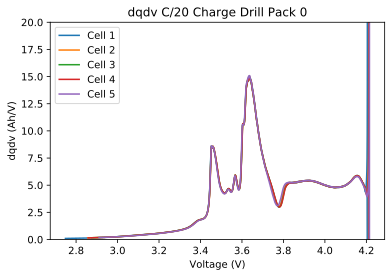

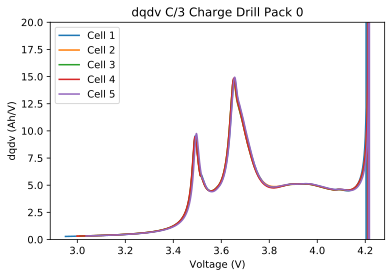

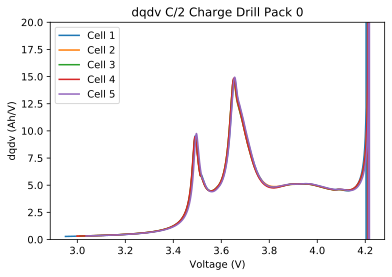

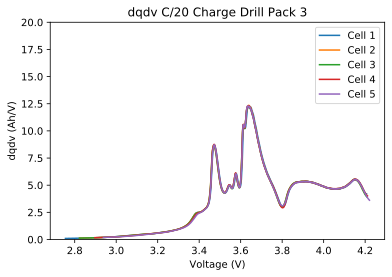

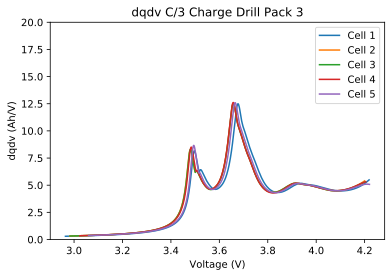

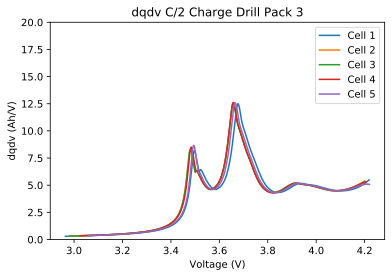

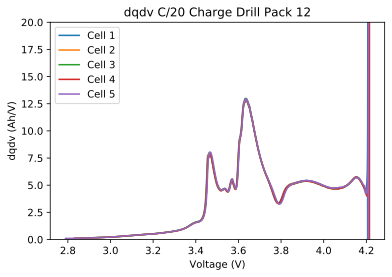

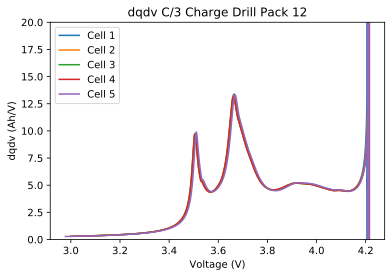

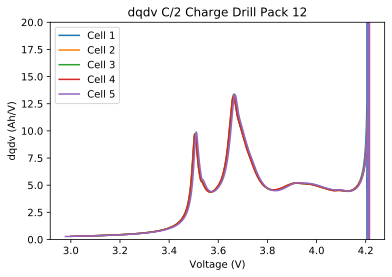

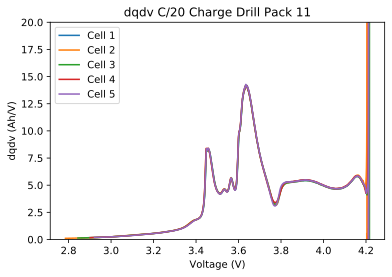

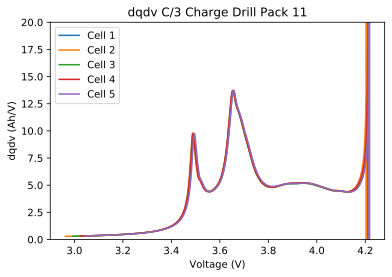

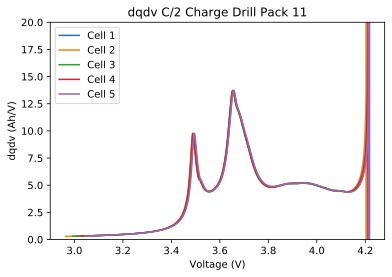

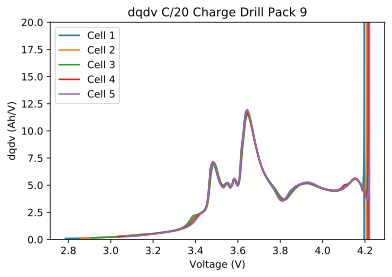

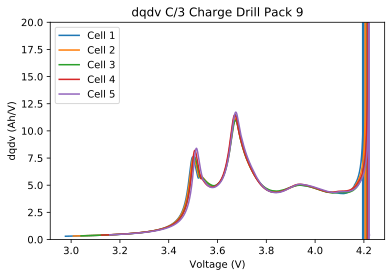

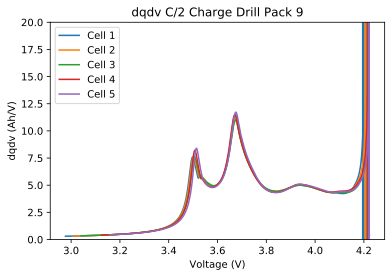

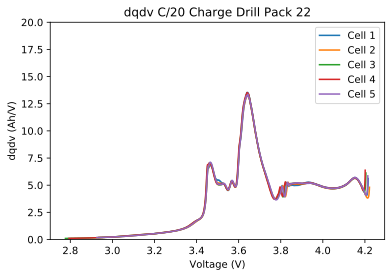

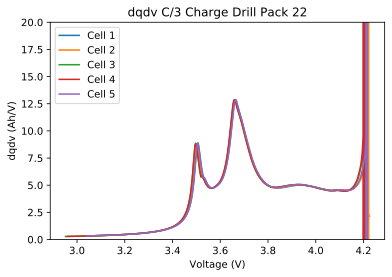

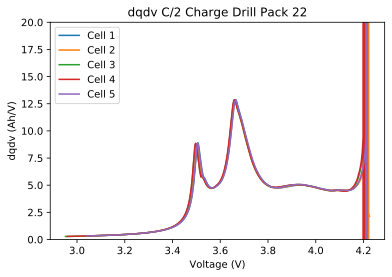

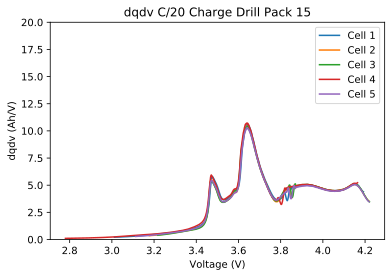

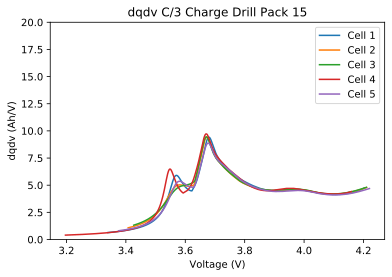

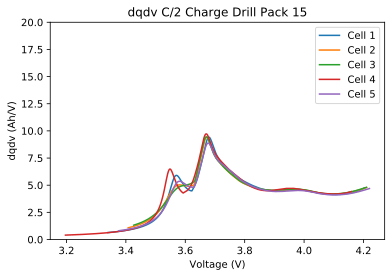

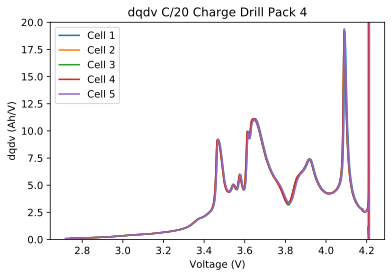

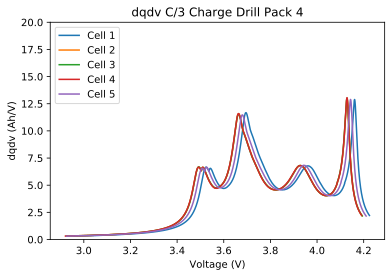

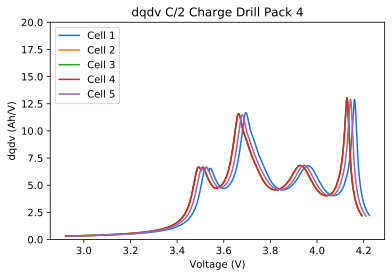

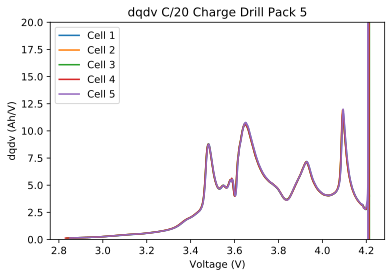

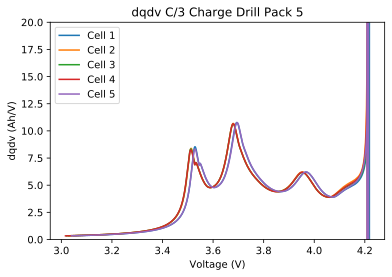

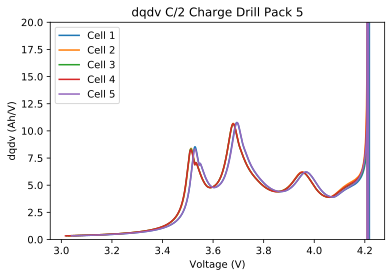

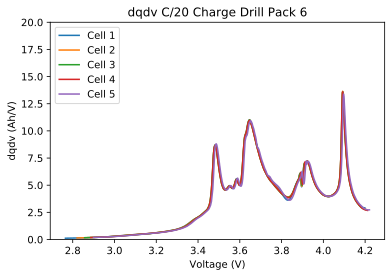

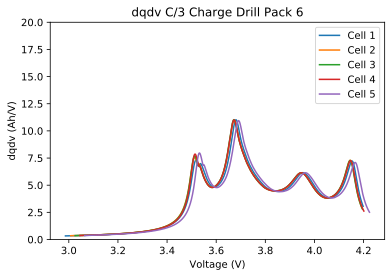

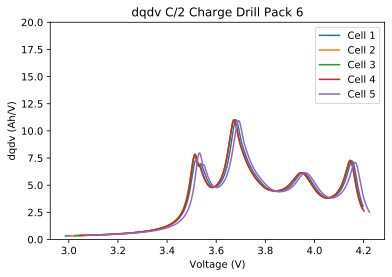

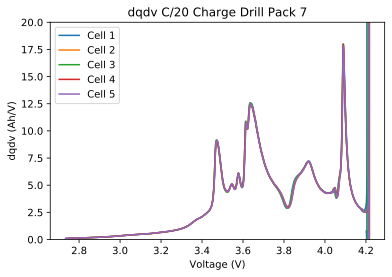

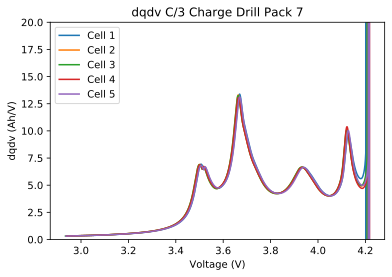

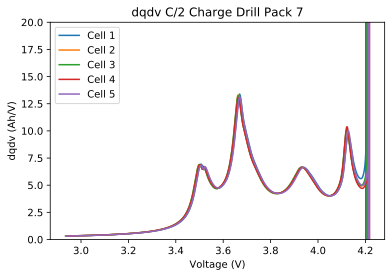

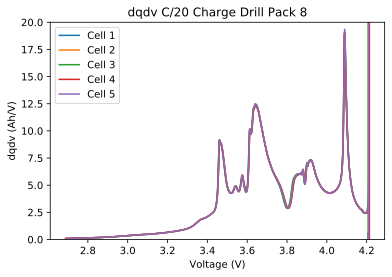

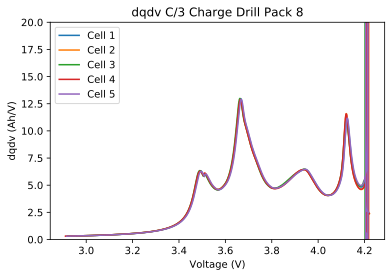

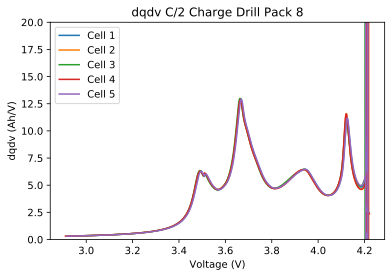

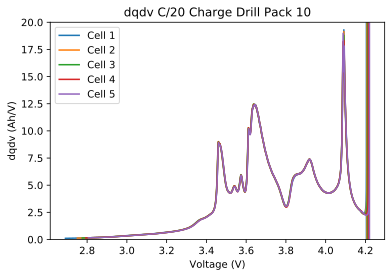

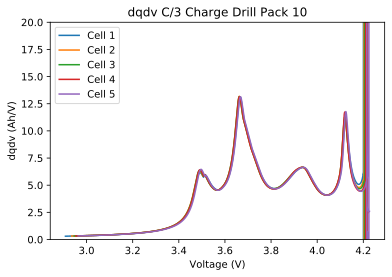

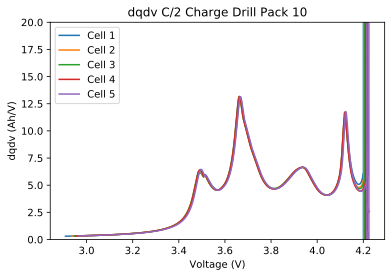

In [9]:
for drill_pack_num in packs: 
    capacity = details_df.loc[drill_pack_num,'weakest_cell_capacity_Ah' ]
    charge_C20_data, charge_C3_data, charge_C2_data = extract_charge_data (drill_pack_num, capacity)
    
    plot_dqdv (charge_C20_data , drill_pack_num,"C/20")
    plot_dqdv (charge_C3_data , drill_pack_num,"C/3")
    plot_dqdv (charge_C3_data , drill_pack_num,"C/2")

### Some comments about dqdv plots 


- Samsung NCA and LG NMC cells display different dqdv plots since they are different chemistries

- For some of the packs, dq/dv curves of cells 1 and 5 shifting towards higher potentials. The reason for this behavior is that for those packs, cell 1 and 5 has a higher measured ohmic resistance due to external resistance of the tabs. This behavior is particularly evident at higher C-rate. At low current rate, the polarization influence on the dq/dv curve is minimal. 
    - dq/dv curves of Cells 1 and 5 are not representative of their internal states

- For the LG packs, the peaks are maintained at C/2 even for pack 15, the pack that is most aged. 

- For the Samsung packs, the fourth peak is only sustained at C/20. It is not persistently maintained at C/3 and C/2. 
 


### Visualizing how dq/dv curves change with decreasing capacity

Each pack's dq/dv curve was represented by the dq/dv curve of the weakest cell of cells 2-4.

In [10]:
def plot_dqdv_across_packs (details_df, packs): 
    pack_df = details_df.loc[packs]
    
    pack_df = pack_df.sort_values(by=['weakest_cell_2_4_2.95_4.1_V_capacity_Ah'], ascending=False)
    packs = pack_df.index
    min_cap = pack_df['weakest_cell_2_4_2.95_4.1_V_capacity_Ah'].min()
    max_cap= pack_df['weakest_cell_2_4_2.95_4.1_V_capacity_Ah'].max()
    color_range = (((max_cap-pack_df['weakest_cell_2_4_2.95_4.1_V_capacity_Ah'])/(max_cap-min_cap))*.4 +.5)
    colors = plt.cm.jet((color_range.to_list()))

    i= 0
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    for drill_pack_num in packs:
        charge_C20_data, charge_C3_data, charge_C2_data = extract_charge_data (drill_pack_num, capacity)
        weakest_cell_2_4 = pack_df.loc[drill_pack_num, 'weakest_cell_2_4']

        window_length = 2951
        polyorder =5


        #C/20 dqdv plots
        Q_f = savgol_filter(charge_C20_data['Q'], window_length, polyorder)
        dQ_f= savgol_filter(charge_C20_data['Q'], window_length, polyorder, 1)
        V_f = savgol_filter(charge_C20_data['Voltage%d'%weakest_cell_2_4], window_length, polyorder)
        dV_f = savgol_filter(charge_C20_data['Voltage%d'%weakest_cell_2_4], window_length, polyorder, 1)
        dQdV_f = dQ_f/dV_f
        ax1.plot(V_f, dQdV_f, label = "Pack %d (Cell %d)"%(drill_pack_num,weakest_cell_2_4), color = colors[i])
        ax1.set_ylim(0,20)
        C_rate = 'C/20'
        ax1.set_xlabel("Voltage (V)")
        ax1.set_ylabel("dqdv")
        ax1.set_ylim(0,20)
        ax1.set_title('dqdv %s Charge across drill packs'%(C_rate))
        ax1.legend()

        #C/3 dqdv plots
        Q_f = savgol_filter(charge_C3_data['Q'], window_length, polyorder)
        dQ_f= savgol_filter(charge_C3_data['Q'], window_length, polyorder, 1)
        V_f = savgol_filter(charge_C3_data['Voltage%d'%weakest_cell_2_4], window_length, polyorder)
        dV_f = savgol_filter(charge_C3_data['Voltage%d'%weakest_cell_2_4], window_length, polyorder, 1)
        dQdV_f = dQ_f/dV_f
        ax2.plot(V_f, dQdV_f, label = "Pack %d (Cell %d)"%(drill_pack_num,weakest_cell_2_4), color = colors[i])
        ax2.set_ylim(0,20)
        C_rate = 'C/3'
        ax2.set_xlabel("Voltage (V)")
        ax2.set_ylabel("dqdv")
        ax2.set_ylim(0,20)
        ax2.set_title('dqdv %s Charge across drill packs'%(C_rate))
        ax2.legend()

        #C/2 dqdv plots
        Q_f = savgol_filter(charge_C2_data['Q'], window_length, polyorder)
        dQ_f= savgol_filter(charge_C2_data['Q'], window_length, polyorder, 1)
        V_f = savgol_filter(charge_C2_data['Voltage%d'%weakest_cell_2_4], window_length, polyorder)
        dV_f = savgol_filter(charge_C2_data['Voltage%d'%weakest_cell_2_4], window_length, polyorder, 1)
        dQdV_f = dQ_f/dV_f
        ax3.plot(V_f, dQdV_f, label = "Pack %d (Cell %d)"%(drill_pack_num,weakest_cell_2_4), color = colors[i])
        ax3.set_ylim(0,20)
        C_rate = 'C/2'
        ax3.set_xlabel("Voltage (V)")
        ax3.set_ylabel("dqdv (Ah/V)")
        ax3.set_ylim(0,20)
        ax3.set_title('dqdv %s Charge across drill packs'%(C_rate))
        ax3.legend()

        i = i +1









### LG dq/dv curve evolution with decreasing capacity

/Users/clementwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


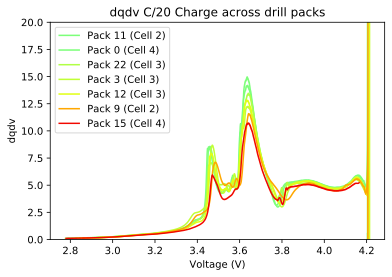

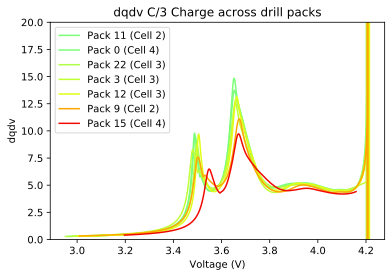

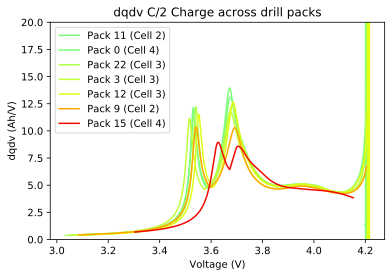

In [11]:
plot_dqdv_across_packs (details_df, LG_packs)

##### For Reference: Green -> Red = high to low capacities. Color Scale based on the capacities of the LG packs and is meant to aid how the dq/dv curves evolves with decreasing capacity. 

### Samsung dq/dv curve evolution with decreasing capacity

/Users/clementwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


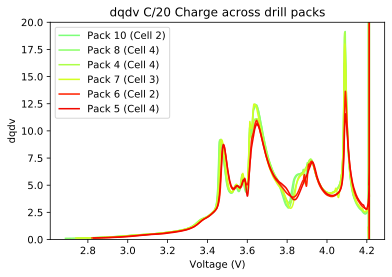

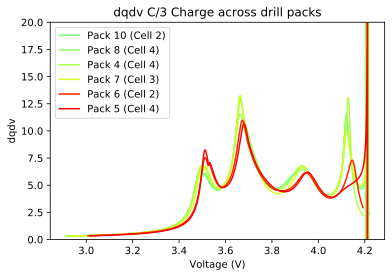

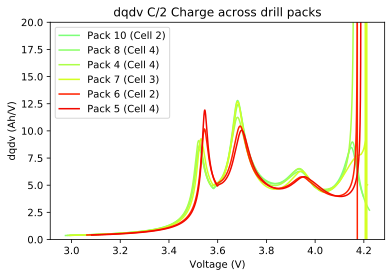

In [12]:
plot_dqdv_across_packs (details_df, samsung_packs)

##### For Reference: Green -> Red = high to low capacities. Note that the color scale is not same as the color scale for LG pack. 

### Comments about dq/dv curves with decreasing capacity
- Observable trends between the peak heights and voltage values at the peak. Need to extract peak heights and voltage values at the peaks and see how they perform as features for capacity estimation

## Extracting dqdv features (peak heights and voltage values at peaks)

Voltage bound of each peak in dq/dv curves 

In [13]:
dqdv_peak_range_df= pd.DataFrame()

#These values were done by inspection
for pack in LG_packs: 
    dqdv_peak_range_df.loc[pack, 'C/2 peak 1 V max'] = 3.6
    dqdv_peak_range_df.loc[pack,'C/2 peak 2 V max'] = 3.8
    dqdv_peak_range_df.loc[pack, 'C/3 peak 1 V max'] = 3.6
    dqdv_peak_range_df.loc[pack,'C/3 peak 2 V max'] = 3.8
    
    dqdv_peak_range_df.loc[pack,'C/20 peak 1 V max'] = 3.5
    dqdv_peak_range_df.loc[pack,'C/20 peak 2 V max'] = 3.8
    dqdv_peak_range_df.loc[pack,'C/20 peak 3 V max'] = 4
    

#Pack 15 C/2 & C/3 boundary modifications
pack = 15
dqdv_peak_range_df.loc[pack,'C/2 peak 1 V max'] = 3.7
dqdv_peak_range_df.loc[pack,'C/2 peak 2 V max'] = 4
dqdv_peak_range_df.loc[pack, 'C/3 peak 1 V max'] = 3.65
dqdv_peak_range_df.loc[pack, 'C/3 peak 2 V max'] = 4


for pack in samsung_packs: 
    dqdv_peak_range_df.loc[pack, 'C/2 peak 1 V max'] = 3.6
    dqdv_peak_range_df.loc[pack,'C/2 peak 2 V max'] = 3.8
    dqdv_peak_range_df.loc[pack,'C/2 peak 3 V max'] = 4
    dqdv_peak_range_df.loc[pack,'C/2 peak 4 V max'] = 4.2
    
    dqdv_peak_range_df.loc[pack, 'C/3 peak 1 V max'] = 3.6
    dqdv_peak_range_df.loc[pack,'C/3 peak 2 V max'] = 3.8
    dqdv_peak_range_df.loc[pack,'C/3 peak 3 V max'] = 4
    dqdv_peak_range_df.loc[pack,'C/3 peak 4 V max'] = 4.2
    
    
    dqdv_peak_range_df.loc[pack,'C/20 peak 1 V max'] = 3.6
    dqdv_peak_range_df.loc[pack,'C/20 peak 2 V max'] = 3.8
    dqdv_peak_range_df.loc[pack,'C/20 peak 3 V max'] = 4
    dqdv_peak_range_df.loc[pack,'C/20 peak 4 V max'] = 4.2



Function that extracts dqdv features (peak heights and voltage values at peaks)

In [14]:
def extract_peak_features (data, dqdv_peak_range_df, drill_pack_num, C_rate, weakest_cell_2_4): 

#     fig, ax = plt.subplots()
    window_length = 2951
    polyorder =5
    Q = savgol_filter(data['Q'], window_length, polyorder)
    dQ= savgol_filter(data['Q'], window_length, polyorder, 1)
    V = savgol_filter(data['Voltage%d'%weakest_cell_2_4], window_length, polyorder)
    dV = savgol_filter(data['Voltage%d'%weakest_cell_2_4], window_length, polyorder, 1)

    dQdV = dQ/dV
#     ax.plot(V, dQdV, label = "Weakest Cell of 2-4: %d"%weakest_cell_2_4)
#     ax.set_xlabel("Voltage (V)")
#     ax.set_ylabel("dqdv")
#     ax.set_ylim(0,20)
#     ax.set_title('dqdv %s Charge Drill Pack %d'%(C_rate, drill_pack_num))


    #Reducing the number of data points in dqdv
    V_sorted, dQdV_sorted = zip(*sorted(zip(V, dQdV)))
    block= 60
    V_sorted_reduced = [0]*(len(V_sorted)//block)
    dQdV_sorted_reduced = [0]*(len(dQdV_sorted)//block)
    for j in range(len(V_sorted_reduced)): 
        if (j+block< len(V_sorted)):
            V_subblock = V_sorted[j*block: j*block+block]
            dQdV_subblock = dQdV_sorted[j*block: j*block+block]
        else: 
            V_subblock= V_sorted[j*block:]
            dQdV_subblock = dQdV_sorted[j*block:]

        V_sorted_reduced[j] = np.average(V_subblock)
        dQdV_sorted_reduced[j] = np.average(dQdV_subblock)

    dQdV = np.asarray(dQdV_sorted_reduced)
    V = np.asarray(V_sorted_reduced)



    #peaks and valleys
    indices_peaks = argrelextrema(dQdV, np.greater) 
    indices_valley = argrelextrema(dQdV, np.less)
    V_1_max = dqdv_peak_range_df.loc[drill_pack_num, '%s peak 1 V max'%C_rate]
    dQdV_peak_1 = dQdV[indices_peaks][V[indices_peaks]<V_1_max].max()
    V_peak_1 = V[indices_peaks][ dQdV[indices_peaks] == dQdV_peak_1][0]

    V_2_max = dqdv_peak_range_df.loc[drill_pack_num,'%s peak 2 V max'%C_rate]
    dQdV_peak_2 = dQdV[indices_peaks][(V[indices_peaks]>V_1_max) & (V[indices_peaks]<V_2_max)].max()
    V_peak_2 = V[indices_peaks][ dQdV[indices_peaks] == dQdV_peak_2][0]
    
#     ax.scatter(V_peak_1, dQdV_peak_1)
#     ax.scatter(V_peak_2, dQdV_peak_2)

    samsung_packs =  [4,5,6,7,8, 10] 
    if (drill_pack_num in samsung_packs):
        V_3_max = dqdv_peak_range_df.loc[drill_pack_num,'%s peak 3 V max'%C_rate]
        V_4_max = dqdv_peak_range_df.loc[drill_pack_num,'%s peak 4 V max'%C_rate]
        try: 
            dQdV_peak_3 = dQdV[indices_peaks][(V[indices_peaks]>V_2_max) 
                                              & (V[indices_peaks]<V_3_max)].max()
            V_peak_3 = V[indices_peaks][ dQdV[indices_peaks] == dQdV_peak_3][0]
#             ax.scatter(V_peak_3, dQdV_peak_3)
        except: 
            dQdV_peak_3= np.nan 
            V_peak_3 = np.nan

        try: 
            dQdV_peak_4 = dQdV[indices_peaks][(V[indices_peaks]>V_3_max) 
                                              & (V[indices_peaks]<V_4_max)].max()
            V_peak_4 = V[indices_peaks][ dQdV[indices_peaks] == dQdV_peak_4][0]
#             ax.scatter(V_peak_4, dQdV_peak_4)
        except: 
            dQdV_peak_4= np.nan 
            V_peak_4 = np.nan
        
#     ax.legend()
    
    if (drill_pack_num in samsung_packs):

        dqdv_features =[dQdV_peak_1, V_peak_1, dQdV_peak_2, V_peak_2,
                        dQdV_peak_3, V_peak_3, dQdV_peak_4, V_peak_4]
    else: 
        dqdv_features =[dQdV_peak_1, V_peak_1, dQdV_peak_2, V_peak_2]

    return dqdv_features

Extracts dqdv features from LG NMC dqdv curves and Samsung NCA curves at C/20, C/3, C/2. Separate dqdv features based on chemistry (LG NMC or Samsung NCA) and C-rate

In [15]:
dqdv20_features_lg = pd.DataFrame(columns = ['dQdV20_peak_1', 'V20_peak_1', 
                                             'dQdV20_peak_2', 'V20_peak_2'])
dqdv3_features_lg = pd.DataFrame(columns = ['dQdV3_peak_1', 'V3_peak_1', 
                                             'dQdV3_peak_2', 'V3_peak_2'])
dqdv2_features_lg = pd.DataFrame(columns = ['dQdV2_peak_1', 'V2_peak_1', 
                                             'dQdV2_peak_2', 'V2_peak_2'])


dqdv20_features_samsung= pd.DataFrame(columns = ['dQdV20_peak_1', 'V20_peak_1', 
                                             'dQdV20_peak_2', 'V20_peak_2',
                                               'dQdV20_peak_3', 'V20_peak_3', 
                                               'dQdV20_peak_4', 'V20_peak_4'])
dqdv3_features_samsung = pd.DataFrame(columns = ['dQdV3_peak_1', 'V3_peak_1', 
                                             'dQdV3_peak_2', 'V3_peak_2',
                                               'dQdV3_peak_3', 'V3_peak_3', 
                                               'dQdV3_peak_4', 'V3_peak_4'])
dqdv2_features_samsung = pd.DataFrame(columns = ['dQdV2_peak_1', 'V2_peak_1', 
                                             'dQdV2_peak_2', 'V2_peak_2',
                                               'dQdV2_peak_3', 'V2_peak_3', 
                                               'dQdV2_peak_4', 'V2_peak_4'])


for drill_pack_num in packs: 
    capacity = details_df.loc[drill_pack_num,'weakest_cell_2_4_2.95_4.1_V_capacity_Ah' ]
    weakest_cell_2_4 = details_df.loc[drill_pack_num,'weakest_cell_2_4' ]
    charge_C20_data, charge_C3_data, charge_C2_data = extract_charge_data (drill_pack_num, capacity)
    
    dqdv20_features = extract_peak_features(charge_C20_data ,dqdv_peak_range_df,drill_pack_num, 'C/20', weakest_cell_2_4)
    dqdv3_features = extract_peak_features(charge_C3_data , dqdv_peak_range_df, drill_pack_num, 
                                                                                    'C/3', 
                                                                                    weakest_cell_2_4)
    dqdv2_features = extract_peak_features(charge_C2_data , dqdv_peak_range_df, drill_pack_num, 
                                                                                    'C/2',
                                                                                 weakest_cell_2_4)
    samsung_packs =  [4,5,6,7,8, 10]
    
    
    
    if (drill_pack_num in samsung_packs):
        df20 = pd.DataFrame([dqdv20_features], columns = dqdv20_features_samsung.columns, index=[drill_pack_num])
        dqdv20_features_samsung = dqdv20_features_samsung.append(df20)


        df3 = pd.DataFrame([dqdv3_features], columns = dqdv3_features_samsung.columns, index=[drill_pack_num])
        dqdv3_features_samsung = dqdv3_features_samsung.append(df3) 

        df2 = pd.DataFrame([dqdv2_features], columns = dqdv2_features_samsung.columns, index=[drill_pack_num])
        dqdv2_features_samsung = dqdv2_features_samsung.append(df2)
    else:
        df20 = pd.DataFrame([dqdv20_features], columns = dqdv20_features_lg.columns, index=[drill_pack_num])
        dqdv20_features_lg = dqdv20_features_lg.append(df20)
                                           
        df3 = pd.DataFrame([dqdv3_features], columns = dqdv3_features_lg.columns, index=[drill_pack_num])
        dqdv3_features_lg = dqdv3_features_lg.append(df3) 
                           
        df2 = pd.DataFrame([dqdv2_features], columns = dqdv2_features_lg.columns, index=[drill_pack_num])
        dqdv2_features_lg = dqdv2_features_lg.append(df2)




/Users/clementwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### All LG Features

In [16]:
dqdv_features_lg = pd.concat([dqdv20_features_lg, dqdv3_features_lg, dqdv2_features_lg], axis=1)

In [17]:
dqdv_features_lg

dQdV20_peak_1  V20_peak_1  dQdV20_peak_2  V20_peak_2  dQdV3_peak_1  \
0        8.557311    3.459199      14.938382    3.635607      9.432555   
3        8.665991    3.470392      12.236088    3.637788      8.275565   
12       7.915869    3.466966      12.802402    3.635614      9.645992   
11       8.374018    3.457595      14.169808    3.637224      9.762496   
9        7.100068    3.485071      11.565145    3.642550      7.571898   
22       7.057190    3.464580      13.429116    3.641569      8.794918   
15       5.925366    3.470944      10.699276    3.640246      6.464910   

    V3_peak_1  dQdV3_peak_2  V3_peak_2  dQdV2_peak_1  V2_peak_1  dQdV2_peak_2  \
0    3.490105     14.836335   3.651677     11.347115   3.533535     13.951470   
3    3.481086     12.521232   3.657066     11.043977   3.517227     11.757385   
12   3.505795     13.134149   3.662974     11.440875   3.553057     12.590740   
11   3.487698     13.722045   3.654557     12.006195   3.532021     13.097767   
9    3.502855     11.099490   3.672495     10.324269   3.541887     10.282444   
22   3.496353     12.861545   3.661297     12.162460   3.540918     12.312383   
15   3.549781      9.716724   3.669830      8.932946   3.627826      8.584195   

    V2_peak_2  
0    3.672067  
3    3.676694  
12   3.684026  
11   3.673720  
9    3.691509  
22   3.680604  
15   3.703820

In [18]:
dqdv_features_lg.to_csv('dqdv_features_lg.csv')

### All Samsung Features

In [19]:
dqdv_features_samsung = pd.concat([dqdv20_features_samsung, dqdv3_features_samsung, dqdv2_features_samsung], axis=1)

In [20]:
dqdv_features_samsung

dQdV20_peak_1  V20_peak_1  dQdV20_peak_2  V20_peak_2  dQdV20_peak_3  \
4        9.209173    3.468678      11.100958    3.645435       7.389298   
5        8.737782    3.480455      10.637672    3.646787       7.131820   
6        8.637222    3.481851      10.954363    3.646267       7.195845   
7        9.146108    3.471972      12.449411    3.633477       7.179805   
8        9.148593    3.461987      12.350696    3.640618       7.310413   
10       9.000701    3.460766      12.425432    3.637821       7.369857   

    V20_peak_3  dQdV20_peak_4  V20_peak_4  dQdV3_peak_1  V3_peak_1  ...  \
4     3.917520      19.053470    4.088912      6.644921   3.493929  ...   
5     3.925692      11.545779    4.092628      8.237620   3.512300  ...   
6     3.923700      13.609547    4.092182      7.532978   3.513087  ...   
7     3.919412      17.957885    4.089468      6.875943   3.498210  ...   
8     3.918396      19.023361    4.088955      6.285479   3.490255  ...   
10    3.918895      19.121282    4.091552      6.302094   3.490764  ...   

    dQdV3_peak_4  V3_peak_4  dQdV2_peak_1  V2_peak_1  dQdV2_peak_2  V2_peak_2  \
4      13.002253   4.129268      9.069951   3.523466     11.228027   3.679605   
5            NaN        NaN     11.875165   3.547018     10.054513   3.698637   
6       7.277845   4.144095     10.094908   3.544136     10.415920   3.689989   
7      10.104267   4.122194      9.215675   3.533256     12.676402   3.682878   
8      11.532126   4.121761      8.612909   3.527745     12.419275   3.683177   
10     11.105078   4.119864      8.236975   3.527311     12.787674   3.682036   

    dQdV2_peak_3  V2_peak_3  dQdV2_peak_4  V2_peak_4  
4       6.524756   3.937020           NaN        NaN  
5       5.777313   3.954305           NaN        NaN  
6       5.765882   3.947758           NaN        NaN  
7       6.290335   3.943369           NaN        NaN  
8       6.265148   3.932989      8.961892   4.151685  
10      6.482421   3.936945      8.466866   4.147255  

[6 rows x 24 columns]

In [21]:
dqdv_features_samsung.to_csv('dqdv_features_samsung.csv')